# Turnpike and homotopy: an example

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min 
        \frac{1}{2}\int_{0}^{1}\left((y_1(t)-1)^2+(y_2(t)-1)^2+(u(t)-2)^2\right) \mathrm{d}t,\\[1.0em]
        \dot{y}_1(t) = t_f\, y_2(t)\\
        \dot{y}_2(t) = t_f\, \left(1-y_1(t)+y_2^3(t)+u(t)\right)\\[1.0em]
        y(0) = (1, 1),\quad y(1) = (3, 0).
    \end{array}
    \right.
$$

## Preliminaries
### Packages

In [1]:
# Standard packages
using LinearAlgebra
using NLsolve
using Plots

# Own files
include("Flow.jl");      # To generate flows of Hamiltonian system
include("Homotopy.jl")   # To compute homotopies
include("Plottings.jl"); # To plot solutions

### Parameters

In [2]:
y0 = [1.; 1.] # Initial point
yf = [3.; 0.] # Final point

ybar = [2.; 0.]    # Solution to the static problem
qbar = [-1.; -1.]; # Lagrange multiplier from the static problem

### Hamiltonian

In [3]:
function H(y, q, u, tf) # Pseudo-Hamiltonian
    y1 = y[1]; y2 = y[2]
    q1 = q[1]; q2 = q[2]
    return (-0.5*((y1-1)^2 + (y2-1)^2 + (u-2)^2) + y2*q1 + (1 - y1 + y2^3 + u)*q2)*tf
end

u(y, q)  = 2. + q[2] # Maximizing control law

H(y, q, tf) = H(y, q, u(y, q), tf); # maximized Hamiltonian

### Flow of the Hamiltonian

In [4]:
f = Flow(H);

### Shooting

In [5]:
# The shooting function
function shoot(q0, q1, λ, tf ; optionsODE = Dict())
    
    # Integration from 0 to 0.5
    z0 = [λ*y0+(1-λ)*ybar ; q0]
    zm1 = f(0., z0, 0.5, λ=tf, optionsODE=optionsODE)
    
    # Integration from 1. to 0.5
    z1 = [λ*yf+(1-λ)*ybar ; q1]
    zm2 = f(1., z1, 0.5, λ=tf, optionsODE=optionsODE)
    
    # Matching at the middle point
    s = zm1 - zm2
    
    return s
end

# test : lambda = 0, tf = 40
λ  = 0.
tf = 40.
println("shoot(qbar, qbar, λ, tf) = ", shoot(qbar, qbar, λ, tf))

shoot(qbar, qbar, λ, tf) = [0.0, 0.0, 0.0, 0.0]


In [6]:
# Resolution of the shooting equation

λ_shoot  = 0.05
tf_shoot = 10.

S(ξ) = shoot(ξ[1:2], ξ[3:4], λ_shoot, tf_shoot)

nl_sol = nlsolve(S, [qbar; qbar]; xtol=1e-8, method=:trust_region, show_trace=true); q0_sol = nl_sol.zero[1:2]; q1_sol = nl_sol.zero[3:4];

display(nl_sol)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.009507e+00              NaN
     1     2.812356e+00     1.110223e-16
     2     2.812356e+00     0.000000e+00
     3     2.812356e+00     0.000000e+00
     4     2.812356e+00     0.000000e+00
     5     2.812356e+00     0.000000e+00
     6     7.539201e-01     8.133038e-02
     7     1.979988e+00     0.000000e+00
     8     4.440810e-01     9.147134e-02
     9     3.166153e-01     5.088333e-02
    10     2.012772e-02     2.070249e-02
    11     1.624971e-04     1.280979e-03
    12     7.209311e-09     1.139099e-05


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-1.0, -1.0, -1.0, -1.0]
 * Zero: [-0.9226235194681129, -1.0498486216329852, -0.9027010765185398, -1.0205351599839694]
 * Inf-norm of residuals: 0.000000
 * Iterations: 12
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 9
 * Jacobian Calls (df/dx): 7

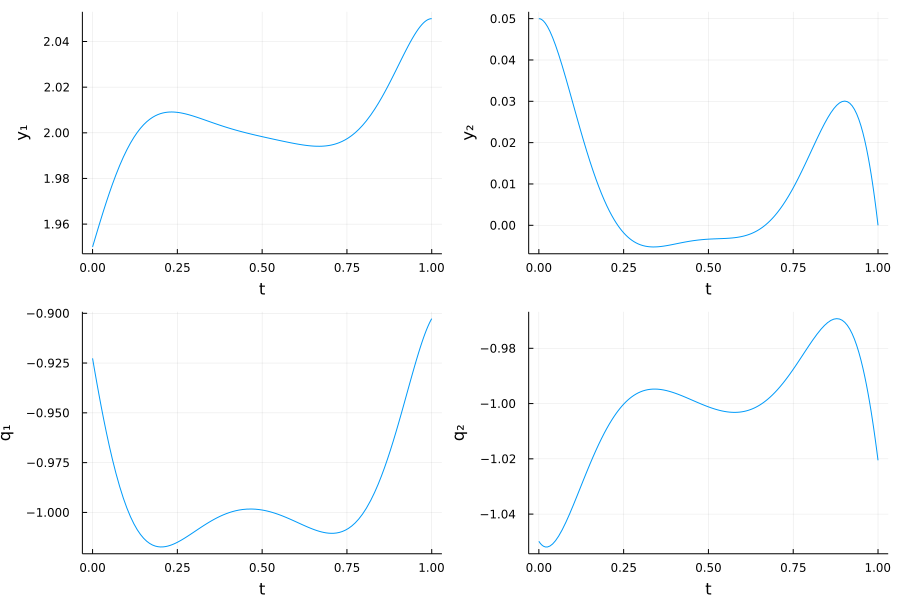

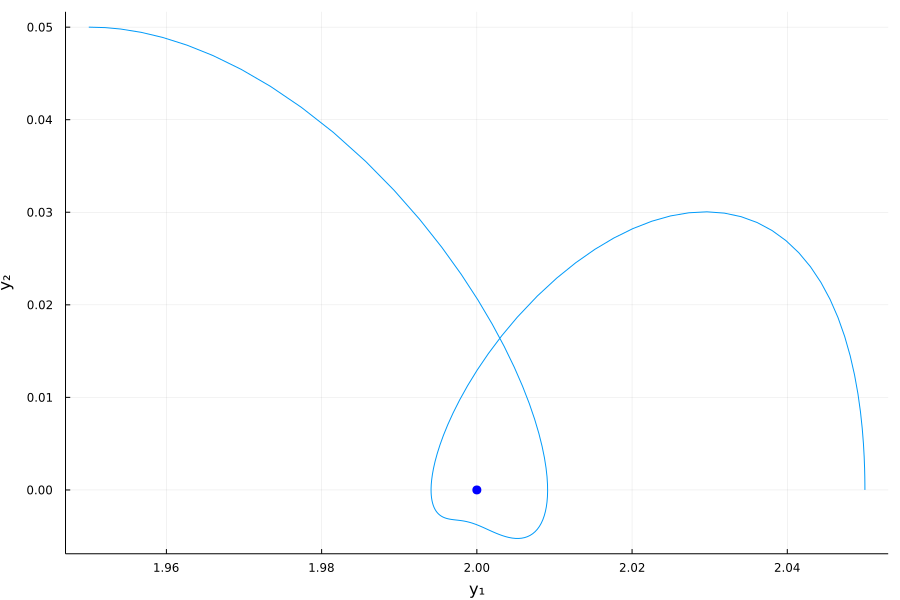

In [7]:
# Display the solution
plot_shoot(y0, q0_sol, yf, q1_sol, ybar, λ_shoot, tf_shoot, f, size=(900, 600))

## Homotopy on the boundary conditions

In [8]:
opt     = Dict([(:algo,Tsit5()),(:reltol,1.e-12),(:abstol,1.e-12)])
tf_bc   = 10.0
S(ξ, λ) = shoot(ξ[1:2], ξ[3:4], λ, tf_bc, optionsODE=opt)
p       = Path(S);

In [9]:
λ₀ = 0.
λ₁ = 1.
path_bc = p([qbar; qbar], λ₀, λ₁; saveat=0.01);


     Calls  |f(x,pars)|     |x|             Homotopic param 

         1  0.00000000e+00  2.00000000e+00  0.00000000e+00
         2  1.59036614e-13  1.99527339e+00  4.63092298e-03
         3  5.64576445e-12  1.98211393e+00  1.77903580e-02
         4  4.60305781e-11  1.96498879e+00  3.56281208e-02
         5  1.67829384e-10  1.94614348e+00  5.65042591e-02
         6  5.59479307e-10  1.92591008e+00  8.10485666e-02
         7  1.44018063e-09  1.90634378e+00  1.08226374e-01
         8  3.26225158e-09  1.88901298e+00  1.37812114e-01
         9  6.42469775e-09  1.87594054e+00  1.69053449e-01
        10  1.14432903e-08  1.86892139e+00  2.01497254e-01
        11  1.25973256e-12  1.86959923e+00  2.34589586e-01
        12  9.57242331e-09  1.87925651e+00  2.67917770e-01
        13  1.32907332e-12  1.89874406e+00  3.01099219e-01
        14  1.46471304e-12  1.92845027e+00  3.33842892e-01
        15  1.67079071e-12  1.96831177e+00  3.65916196e-01
        16  2.01621236e-12  2.01788884e+00  3.971521

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


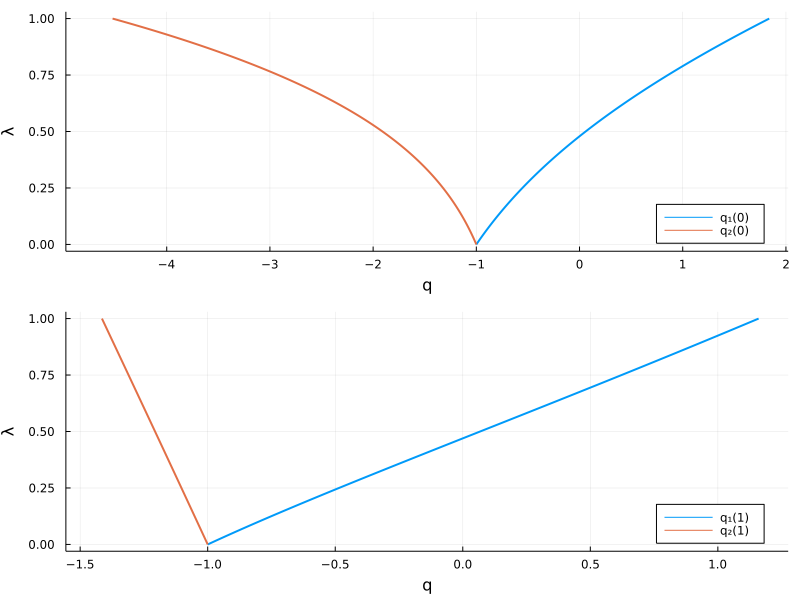

In [10]:
plot_path_bc(path_bc, size=(800, 600))

┌ Info: Saved animation to 
│   fn = /Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_bc.mp4
└ @ Plots /Users/ocots/.julia/packages/Plots/Ra8fG/src/animation.jl:126
┌ Info: Saved animation to 
│   fn = /Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_bc.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_bc.gif")
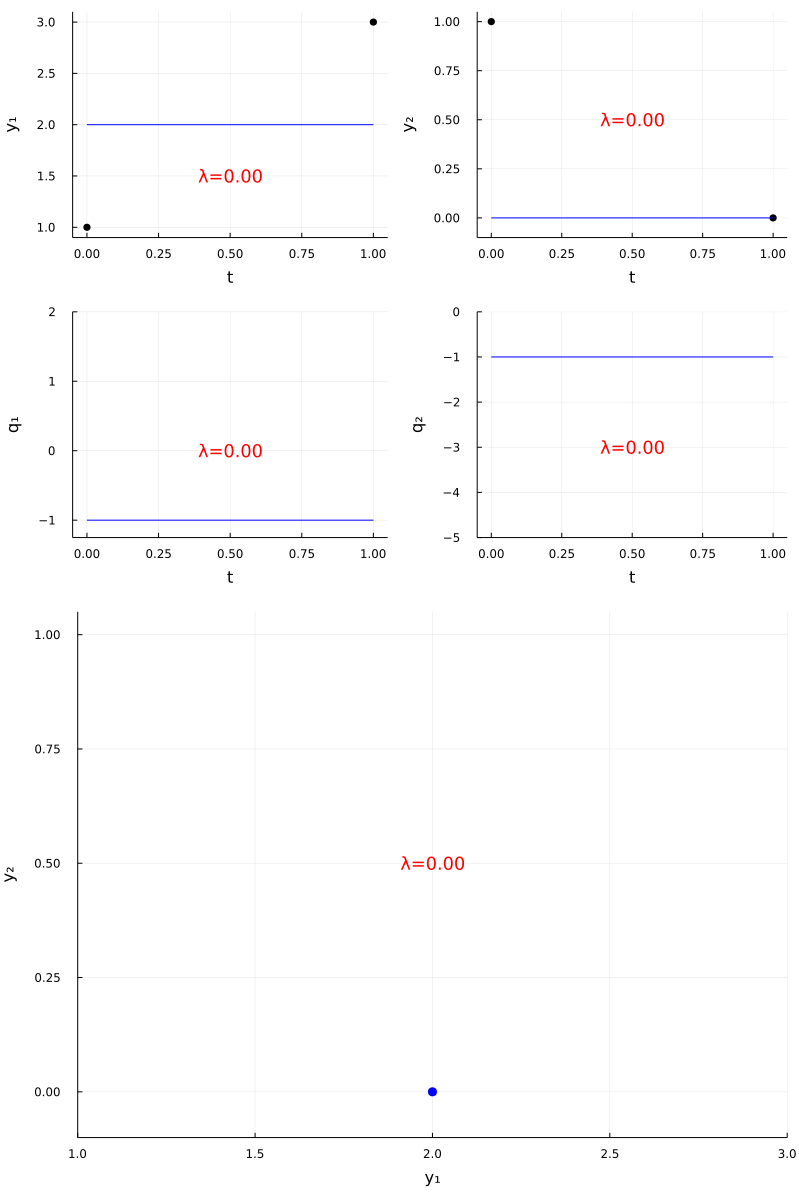

In [11]:
plot_traj_bc(path_bc, y0, yf, ybar, tf_bc, f, size=(800, 1200))

## Homotopy on the final time

In [12]:
S(ξ, tf) = shoot(ξ[1:2], ξ[3:4], λ₁, tf, optionsODE=opt)
p = Path(S);

In [13]:
ξ₀  = path_bc[1:4, end]
tf₀ = tf_bc
tf₁ = 60.
path_tf = p(ξ₀, tf₀, tf₁; saveat=1.0);


     Calls  |f(x,pars)|     |x|             Homotopic param 

         1  2.66269047e-08  5.21516339e+00  1.00000000e+01
         2  2.66263527e-08  5.21514408e+00  1.00189728e+01
         3  2.66258934e-08  5.21506014e+00  1.01094485e+01
         4  2.66323549e-08  5.21495482e+00  1.02506644e+01
         5  2.66466621e-08  5.21486898e+00  1.04132906e+01
         6  2.67138436e-08  5.21480798e+00  1.06172659e+01
         7  2.68675121e-08  5.21479019e+00  1.08503628e+01
         8  2.72448665e-08  5.21482088e+00  1.11197978e+01
         9  2.79826050e-08  5.21489747e+00  1.14226261e+01
        10  2.94331549e-08  5.21500967e+00  1.17651761e+01
        11  3.23248024e-08  5.21514013e+00  1.21551302e+01
        12  3.92838206e-08  5.21526803e+00  1.26119239e+01
        13  4.72675361e-08  5.21535865e+00  1.30955899e+01
        14  5.35329063e-08  5.21540433e+00  1.35843876e+01
        15  5.97255682e-08  5.21541507e+00  1.40993107e+01
        16  6.51952565e-08  5.21540279e+00  1.464203

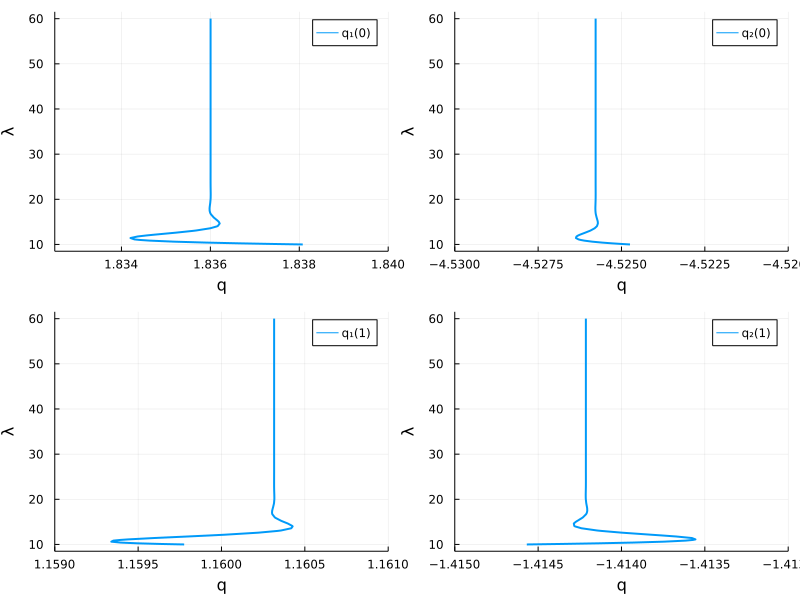

In [14]:
plot_path_tf(path_tf, size=(800, 600))

┌ Info: Saved animation to 
│   fn = /Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_tf.mp4
└ @ Plots /Users/ocots/.julia/packages/Plots/Ra8fG/src/animation.jl:126
┌ Info: Saved animation to 
│   fn = /Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_tf.gif
└ @ Plots /Users/ocots/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/Users/ocots/Boulot/recherche/Logiciels/dev/ct/gallery/examples/homotopy-julia/traj_tf.gif")
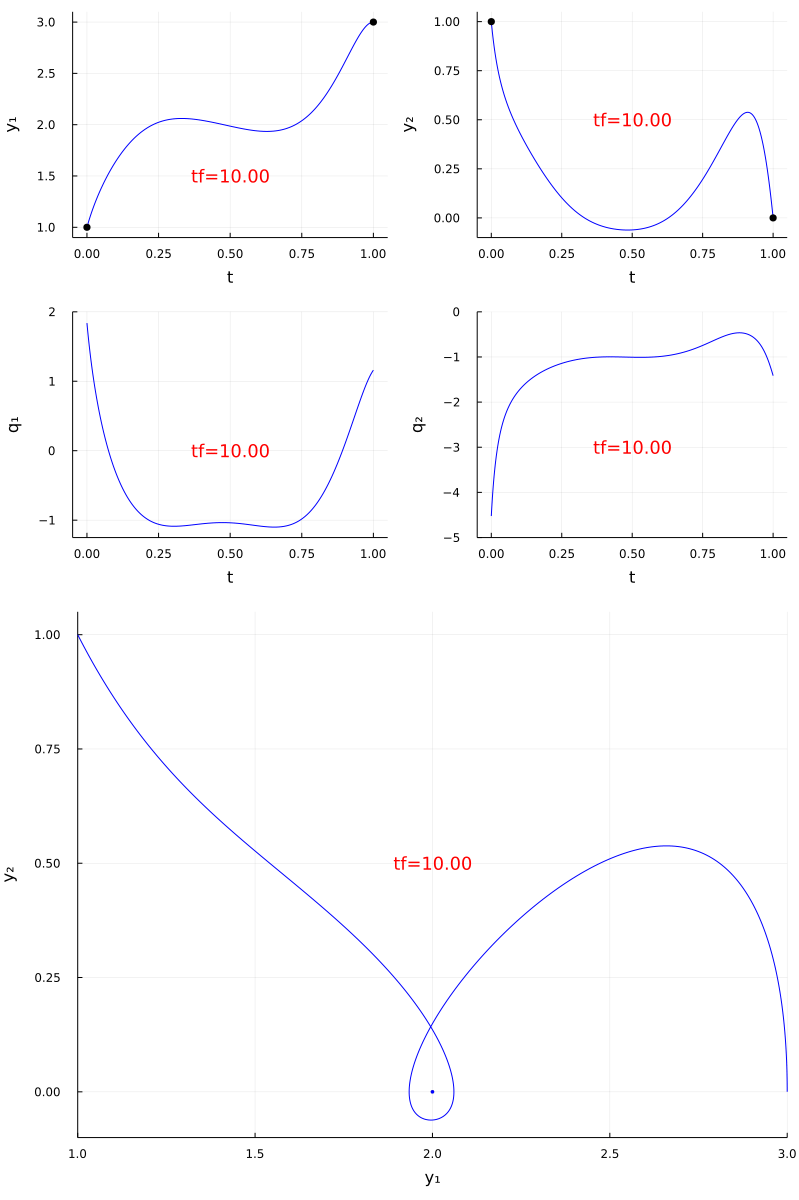

In [15]:
plot_traj_tf(path_tf, y0, yf, ybar, λ₁, f, size=(800, 1200))

[thumbnail](thumbnail.png)

## Annexes

### Flow

[Back to Flow](#Flow-of-the-Hamiltonian)

In [16]:
;pygmentize Flow.jl

# Flow
using LinearAlgebra
using ForwardDiff
using DifferentialEquations
#using ODEInterfaceDiffEq
#using Sundials

grad(f, x) = ForwardDiff.gradient(f, x)

jac(f, x) = ForwardDiff.jacobian(f, x)

function Flow(h)
    """
    f = Flow(h)
    Build the Hamiltonian flow
    
    Input:
    h : Hamiltonian, function
        trueH = h(x,p;par=[])
        Input:
            x : state, Float(n)
            p : co-state, Float(n)
            par : parameters
        Output:
            trueH : value of the Hamiltonian, Float
    Output
    f : flow, function
        sol = f(tspan, z0; λ=[], optionsODE = Dict()))
        Input:
            tspan : tuple of initial and final time (t0, tf)
            z0 : initial point, float(2n)
        Optional input:
            λ : parameters
            optionsODE : dictionary of options for the numerical integration
        Output:
            sol : solution of the (IVP)
       
        sol = f(t0, z0, tf; λ=[], optionsODE = Dict()))
        Output:
     

### Homotopy

[Back to Homotopy](#Homotopy-on-the-boundary-conditions)

In [17]:
;pygmentize Homotopy.jl

# Path following,
# Input
# homotopy and jacobian
#
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Plots
using Printf

function Path(F)

    jac(f, x) = ForwardDiff.jacobian(f, x)
    """
    path = Path(F)
    Build the path following 
    
    Input:
    F : Homotopy
        val = F(x,λ)
        Input:
            x : Float(n)
            λ : homotopic parameter Float
        Output:
            val : value of the Homotopy, Float(n)
    Output
        H : pathfollowing function
        sol = H(x0, λ0, λf; sf=1e4, abstol=1e-8, reltol=1e-8, display=true)
            Input:
                x0 : initial point, Foat(n)
                λ0 : initial value of the homotopic parameter, Float
                λf : final value of the homotopic parameter, Float

            Optional input
                sf : max value of sf, Float
                abstol : Absolute tolerance for the numerical integration, Float
                reltol : Relative tolerance for the numerical 

In [18]:
;pygmentize Plottings.jl

using Plots.PlotMeasures

function __size_shoot()
    return (900,600)
end

function __size_path()
    return (800,600)
end

function __size_traj()
    return (800,1200)
end

function plot_shoot(y0, q0, yf, q1, ybar, λ, tf, f; size=__size_shoot())
    
    z0 = [λ*y0+(1-λ)*ybar ; q0]
    ode_sol = f((0.,0.5), z0, λ=tf)
    T1 = ode_sol.t
    X1 = ode_sol[1:2,:]
    P1 = ode_sol[3:4,:]

    z1 = [λ*yf+(1-λ)*ybar ; q1]
    ode_sol = f((1.,0.5), z1, λ=tf)
    T2 = ode_sol.t;      T2 = T2[end:-1:1]
    X2 = ode_sol[1:2,:]; X2 = X2[:,end:-1:1]
    P2 = ode_sol[3:4,:]; P2 = P2[:,end:-1:1]

    T = [T1;T2]
    X = [X1 X2]
    P = [P1 P2]

    px1 = plot(T,X[1,:], xlabel = "t", ylabel = "y₁", legend=false)
    px2 = plot(T,X[2,:], xlabel = "t", ylabel = "y₂", legend=false)
    pp1 = plot(T,P[1,:], xlabel = "t", ylabel = "q₁", legend=false)
    pp2 = plot(T,P[2,:], xlabel = "t", ylabel = "q₂", legend=false)
    p_phase = plot(X[1,:], X[2,:], xlabel = "y₁", ylabel = "y₂", legend=false)
    plot!